In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from DataPreparation import *

# Paths
img_dir = 'Datasets/Chestxray/images'
output_dir = 'Datasets/Chestxray/Output_Skip'
img_name = 'CHNCXR_0062_0.png'

df, img = load_image_and_samples(img_dir, output_dir, img_name)
node_groups = df.groupby('Node')

In [55]:
# Find uncertainty when drawing from prior
img_dir = 'Datasets/Chestxray/Test'
output_dir_pior = 'Datasets/Chestxray/Test/PriorSamples'
img_name = 'sample.png'

df_prior, _ = load_image_and_samples(img_dir, output_dir_pior, img_name)
node_groups = df_prior.groupby('Node')
stds = node_groups[['X', 'Y']].std()
sigma = (stds['X'] + stds['Y']) / 2

print(f"Incerteza promedio sampleando de prior: {sigma.mean():.2f}")

Incerteza promedio sampleando de prior: 143.09


In [65]:
# Find uncertainty when drawing from images with no information
img_dir = 'Datasets/Chestxray/Test/images'
output_dir_pior = 'Datasets/Chestxray/Test/out'
imgs = os.listdir(img_dir)

for img_name in imgs:
    df_prior, img = load_image_and_samples(img_dir, output_dir_pior, img_name)
    node_groups = df_prior.groupby('Node')
    stds = node_groups[['X', 'Y']].std()
    sigma = (stds['X'] + stds['Y']) / 2
    print(f"Incerteza promedio para {img_name}: {sigma.mean():.2f}")

Incerteza promedio para random_uniform.png: 8.17
Incerteza promedio para random_gaussian.png: 7.69
Incerteza promedio para black_square.png: 119.99


In [2]:
def process_and_store_sigma(subdir, img_dir, output_dir):
    """Processes corrupted images and returns a sigma dictionary."""
    img_dir_path = os.path.join(img_dir, 'Corrupted', subdir)
    output_dir_path = os.path.join(output_dir, 'Corrupted', subdir)
    
    selected_images = {
        "_".join(file.split('_')[:-1]) + ".png"
        for file in os.listdir(img_dir_path)
    }
    
    return process_corr_images(img_dir_path, output_dir_path, selected_images)

## Corruption

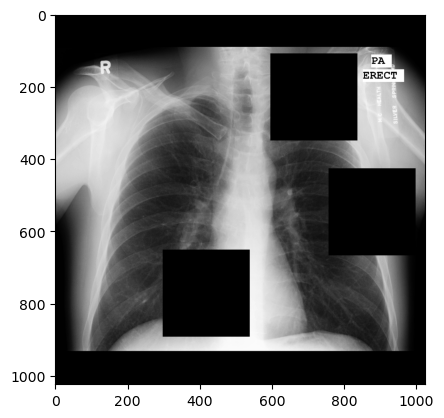

In [62]:
np.random.seed(4)

img_name = 'MCUCXR_0022_0.png'
df, img = load_image_and_samples(img_dir, output_dir, img_name)
file_name = img_name.strip('.png')
all_landmarks = extract_landmarks(file_name, split=False)

landmarks_H = sample_landmarks(all_landmarks, 'H', n_samples=0)
landmarks_RL = sample_landmarks(all_landmarks, 'RL', n_samples=1)
landmarks_LL = sample_landmarks(all_landmarks, 'LL', n_samples=3)

landmarks = np.vstack([landmarks_H, landmarks_RL, landmarks_LL[1:]]).astype(int)

corrupted_image = apply_occlusion(
        image=img,
        landmarks=landmarks,
        size=120
    )

plt.imshow(corrupted_image, cmap='gray')

In [ ]:
all_images = os.listdir(img_dir)
all_images = [img for img in all_images if img.endswith('.png')]

datasets = {
    'CH': [os.path.join(img_dir, img) for img in all_images if img.startswith('CH')],
    'MCU': [os.path.join(img_dir, img) for img in all_images if img.startswith('MCU')],
    'Other': [os.path.join(img_dir, img) for img in all_images if not (img.startswith('CH') or img.startswith('MCU'))]
}

random.seed(4)
output_dir_blend = 'Datasets/Chestxray/images/Corrupted/morphing'
N_samples = 50
blend_images(datasets, N_samples, output_dir_blend, alpha_step=0.1)

In [66]:
np.random.seed(1)
random.seed(1)

def sample_images(img_dir, n_samples=15):
    all_images = [f for f in os.listdir(img_dir) if f.endswith('.png')]
    selected_images = random.sample(all_images, min(n_samples, len(all_images)))
    return selected_images

selected_images = sample_images(img_dir, n_samples=75)
occlusion_dir = os.path.join(img_dir, 'Corrupted', 'occlusion')
os.makedirs(occlusion_dir, exist_ok=True)

for img_name in selected_images:
    df, img = load_image_and_samples(img_dir, output_dir, img_name)
    file_name = img_name.strip('.png')
    all_landmarks = extract_landmarks(file_name, split=False)

    landmarks_H = sample_landmarks(all_landmarks, 'H', n_samples=0)
    landmarks_RL = sample_landmarks(all_landmarks, 'RL', n_samples=2)
    landmarks_LL = sample_landmarks(all_landmarks, 'LL', n_samples=2)

    landmarks = np.vstack([landmarks_H, landmarks_RL, landmarks_LL]).astype(int)

    corrupted_image = apply_occlusion(
        image=img,
        landmarks=landmarks,
        size=100
    )

    output_path = os.path.join(occlusion_dir, f"{file_name}_4.png")
    cv2.imwrite(output_path, corrupted_image)

## Uncertainty map

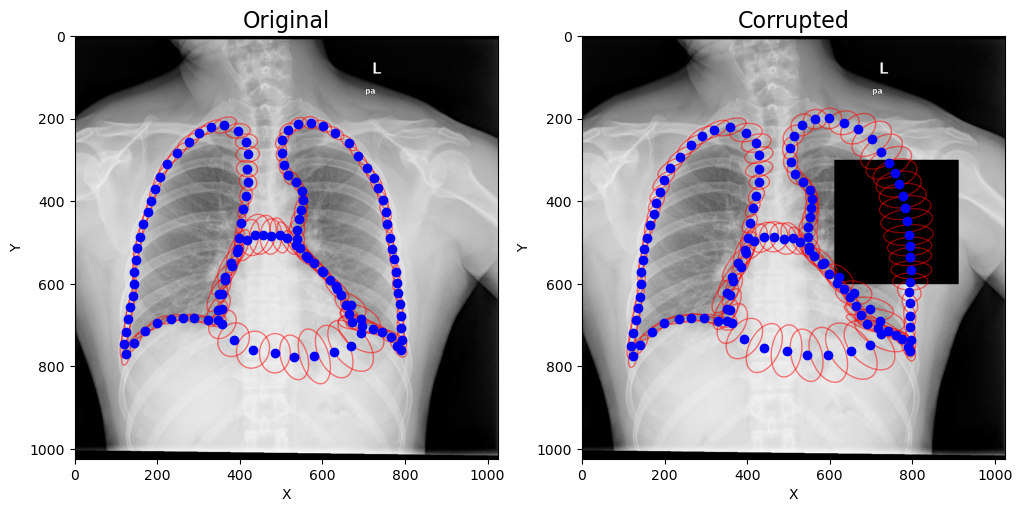

In [16]:
img_dir_corr = 'Datasets/Chestxray/images/Corrupted/occlusion'
output_dir_corr = 'Datasets/Chestxray/Output_Skip/Corrupted/occlusion'

img_name_orig = 'CHNCXR_0080_0.png'
img_name_corr = f"{img_name_orig.strip('.png')}_1.png"

df_orig, img_orig = load_image_and_samples(img_dir, output_dir, img_name_orig)
df_corr, img_corr = load_image_and_samples(img_dir_corr, output_dir_corr, img_name_corr)

fig, axes = plot_comparison(
    df_orig, img_orig, df_corr, img_corr,
    plot_fn=plot_mean_with_uncertainty,
    use_error_bars=False,
    scale_factor=8
)

/home/matias/Documents/proyectos/HybridGNet-uncertainty/DataPreparation/plotting.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


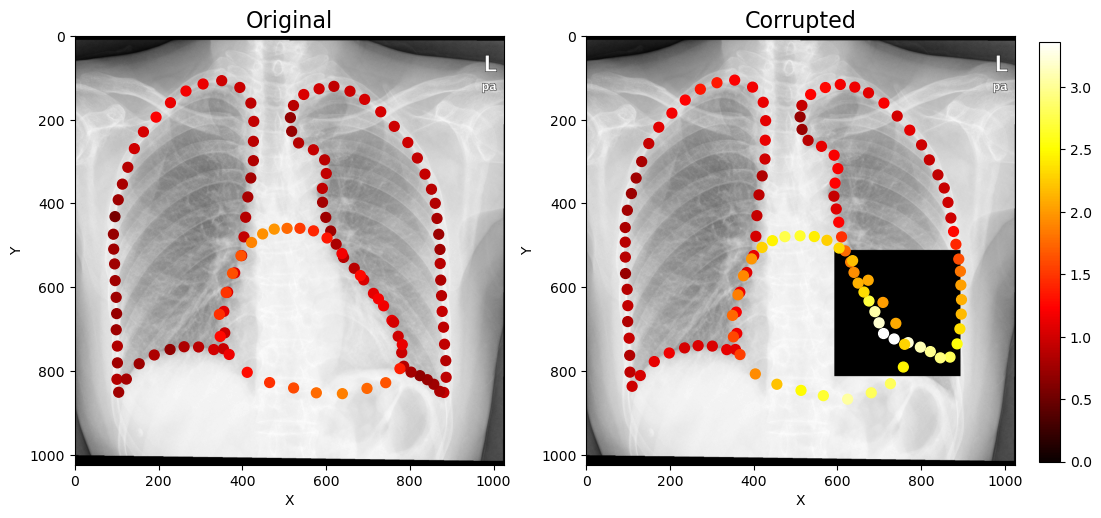

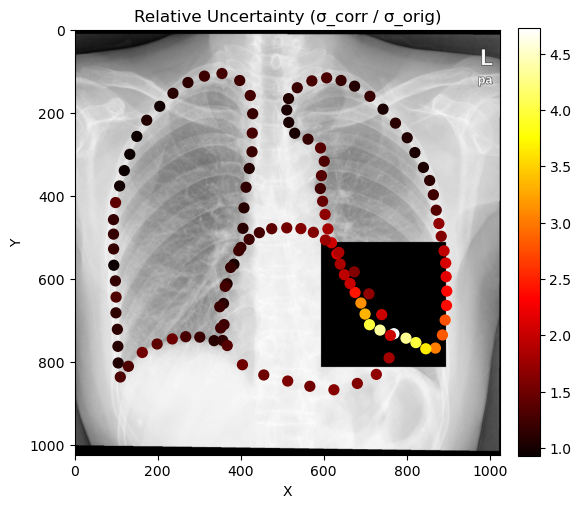

In [23]:
img_name_orig = 'CHNCXR_0096_0.png'
img_name_corr = f"{img_name_orig.strip('.png')}_1.png"

df_orig, img_orig = load_image_and_samples(img_dir, output_dir, img_name_orig)
df_corr, img_corr = load_image_and_samples(img_dir_corr, output_dir_corr, img_name_corr)

vmax = compute_global_vmax(df_orig, df_corr)

fig, axes = plot_comparison(
    df_orig, img_orig, df_corr, img_corr,
    plot_fn=plot_mean_with_color_gradient,
    show_global_bar=True,
    vmax=vmax,
    show_bar=False
)

fig, ax, scatter = plot_relative_uncertainty(
    df_orig, df_corr, img_corr)

/home/matias/Documents/proyectos/HybridGNet-uncertainty/DataPreparation/plotting.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


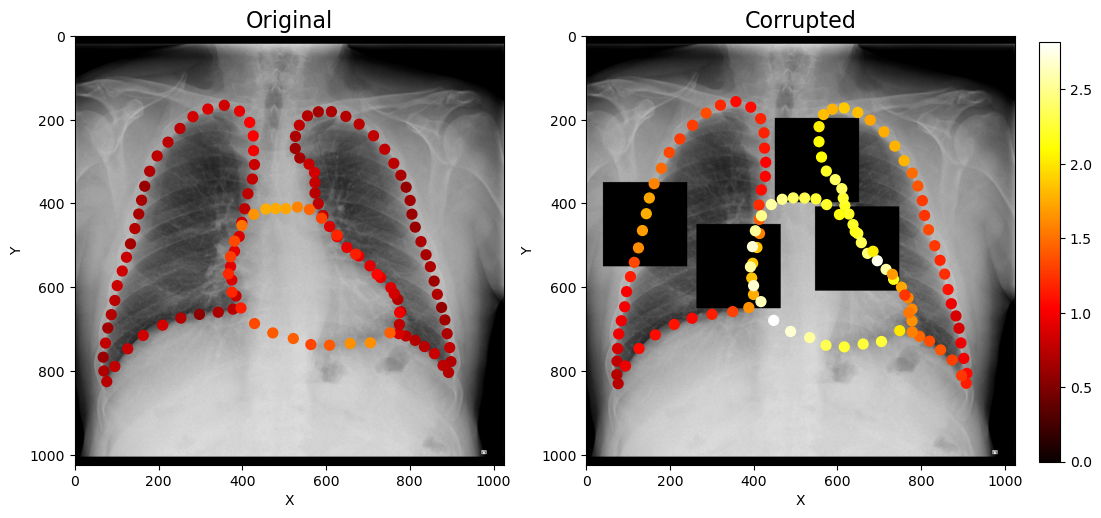

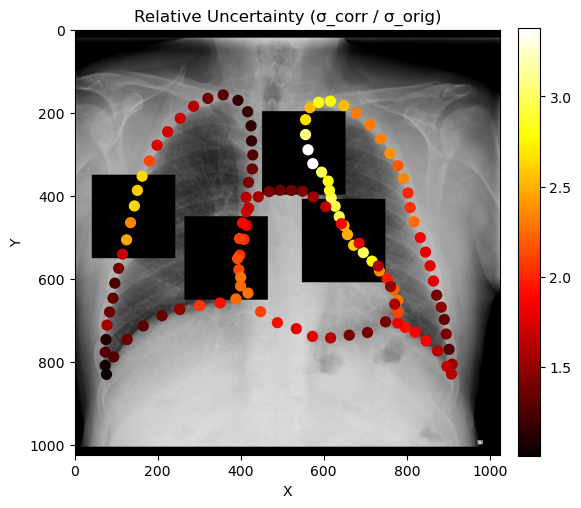

In [25]:
img_name_orig = '199072368172967010909636348828886390156_co5vik.png'
img_name_corr = f"{img_name_orig.strip('.png')}_4.png"

df_orig, img_orig = load_image_and_samples(img_dir, output_dir, img_name_orig)
df_corr, img_corr = load_image_and_samples(img_dir_corr, output_dir_corr, img_name_corr)

fig, axes = plot_comparison(
    df_orig, img_orig, df_corr, img_corr,
    plot_fn=plot_mean_with_color_gradient,
    show_global_bar=True,
    vmax=compute_global_vmax(df_orig, df_corr),
    show_bar=False
)

fig, ax, scatter = plot_relative_uncertainty(
    df_orig, df_corr, img_corr)

/home/matias/Documents/proyectos/HybridGNet-uncertainty/DataPreparation/plotting.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


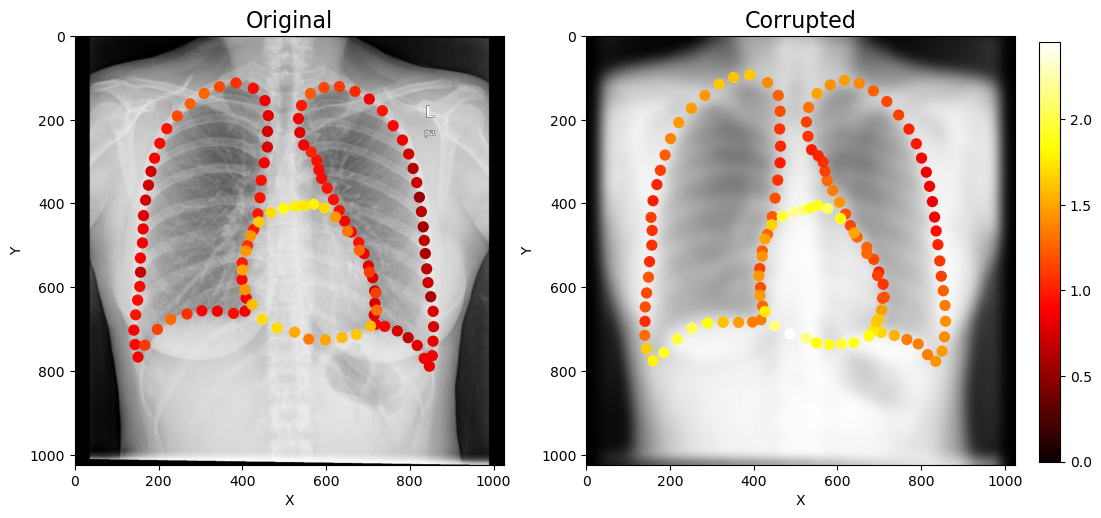

In [12]:
img_dir_corr = 'Datasets/Chestxray/images/Corrupted/blurring/gaussian'
output_dir_corr = 'Datasets/Chestxray/Output_Skip/Corrupted/blurring/gaussian'
img_name_orig = 'CHNCXR_0084_0.png'
img_name_corr = f"{img_name_orig.strip('.png')}_48.png"

df_orig, img_orig = load_image_and_samples(img_dir, output_dir, img_name_orig)
df_corr, img_corr = load_image_and_samples(img_dir_corr, output_dir_corr, img_name_corr)

fig, axes = plot_comparison(
    df_orig, img_orig, df_corr, img_corr,
    plot_fn=plot_mean_with_color_gradient,
    show_global_bar=True,
    vmax=compute_global_vmax(df_orig, df_corr),
    show_bar=False
)